# Comparison of greedy strategy with plasmidSPAdes and mob_recon

In [1]:
import linecache
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

from IPython.display import Image

In [2]:
def parse_structure(filename):
    with open(filename) as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            # number of reference chromosomes:
            if line.startswith('number of reference c'):
                skip_ref_chromosomes = i + 1
                continue
                
            # number of reference plasmids:
            if line.startswith('number of reference p'):
                skip_ref_plasmids = i + 1
                continue
                
            # number of predicted plasmids:
            if line.startswith('number of p'):
                skip_pred_plasmids = i + 1
                continue
            
            # > predicted plasmid covers <proportion> of reference plasmid
            if line.startswith('> pr'):
                skip_ref_by_pred = i + 1
                continue
            
            # > reference plasmid covers <proportion> of predicted plasmid
            if line.startswith('> r'):
                skip_pred_by_ref = i + 1
                continue
                
            # > in total, how much of predicted plasmid is covered by reference plasmids
            if line.startswith('> in total, how much of p'):
                skip_pred_by_all = i + 1
                continue
                
            # > in total, how much of reference plasmid is covered by predicted plasmids
            if line.startswith('> in total, how much of r'):
                skip_ref_by_all = i + 1
                continue
            
            # > pairs of predicted and reference plasmids with coverage >= ... in both directions
            if line.startswith('> pa'):
                skip_mutual = i + 1
                continue
            
            # > summary scores
            if line.startswith('> s'):
                skip_summary_scores = i + 1
                break
        
        return skip_ref_chromosomes, skip_ref_plasmids, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, \
                skip_pred_by_all, skip_ref_by_all, skip_mutual, skip_summary_scores

def read_table(file, skip_rows, num_rows, h = 0, s = '\t', col_sums = False, renaming = {}):
    df = pd.read_csv(file, skiprows = skip_rows, nrows = num_rows, sep = s, header = h)
    if col_sums:
        df.loc[len(df.index)] = ['Total'] + list(df.drop(df.columns[0], axis = 1).sum())
    df.rename(columns = renaming, inplace = True)
    return df

def list_plasmids(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'plasmid', 1: 'length (nt)'})
    df.plasmid = [v[1:-1] for v in df.plasmid]
    return df[['plasmid', 'length (nt)']]

def list_scores(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'score', 1: 'value'})
    df['score'] = [v[:-1].replace('score_ref_coverage', 'recall').replace('score_pred_coverage', 'precision').replace('overall_score', 'overall') for v in df['score']]
    return df

def list_correspondences(file, skip_rows, num_rows):
    first_line = linecache.getline(file, skip_rows + 1).strip()
    if first_line == 'none':
        print('No high mutual correspondence found.')
        #return pd.DataFrame({'reference': [], 'prediction': [], 'recall': [], 'precision': []})
    else:        
        df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'reference', 2: 'prediction', 3: 'recall', 5: 'precision'})
        df['recall'] = [float(v[1:]) for v in df['recall']]
        df['precision'] = [float(v[:-1]) for v in df['precision']]
        return df[['reference', 'prediction', 'recall', 'precision']]
    
def plot_scores(information, score_labels):
    # information = list of tuples of from (file, label)
    pos = list(range(len(score_labels)))
    width = 1 / (len(information) + 2)

    fig, ax = plt.subplots(figsize = (10, 5))

    offset = -len(information) / 2
    for file, lab in information:
        plt.bar([p + offset * width for p in pos], list_scores(file, parse_structure(file)[-1], len(score_labels))['value'], width, label = lab)
        offset += 1

    ax.set_ylabel('score')
    ax.set_xticks([p - 0.5 * width for p in pos])
    ax.set_xticklabels(score_labels)
    ax.legend(bbox_to_anchor = (1, 0.5))

    plt.grid()
    plt.show()

plasmidSPAdes and mob_recon were compared against to two versions of the greedy strategy differing in the plasmid-extension step. Possible extensions were scored by their gene coverage and the deviation from the (current) 'average' read depth of the plasmid, which was computed as either the mean or the median read depth of the contigs associated with the plasmid so far. In both cases, we took the length of the contigs into consideration. The predicted plasmids from both versions were evaluated once as contig sets (like plasmidSPAdes and mob_recon) and once as single linear sequences (obtained by concatenating the contigs in the order and orientation proposed by the greedy strategy).

**We used the following metrics / scores:**    
*Precision*: proportion of predicted plasmid covered by reference plasmids (aka score_pred_coverage).    
*Recall*: proportion of reference plasmid covered by predicted plasmids (aka score_ref_coverage).    

Both were summarised (averaged) into *overall_score*.

## Sample 103
---

In [3]:
score_labels = ['recall', 'precision', 'overall']

# evaluation files
sample_id = 103
greedy_mean = "sample_%i/%i_greedy_mean.csv" % (sample_id, sample_id)
greedy_mean_contigs = "sample_%i/%i_greedy_mean_contigs.csv" % (sample_id, sample_id)
greedy_median = "sample_%i/%i_greedy_median.csv" % (sample_id, sample_id)
greedy_median_contigs = "sample_%i/%i_greedy_median_contigs.csv" % (sample_id, sample_id)
mob_recon = "sample_%i/%i_mob_recon.csv" % (sample_id, sample_id)
plasmidspades = "sample_%i/%i_plasmidSPAdes.csv" % (sample_id, sample_id)

# reference information
_, skip_ref_plasmids, skip_pred_plasmids, _, _, _, _, _, _ = parse_structure(greedy_mean)
num_ref_plasmids = skip_pred_plasmids - skip_ref_plasmids - 3

**List of reference plasmids**

In [4]:
list_plasmids(greedy_mean, skip_ref_plasmids, num_ref_plasmids)

,plasmid,length (nt)
0,CP020824.1,59372


**Overview of the scores on this sample for the different tools **

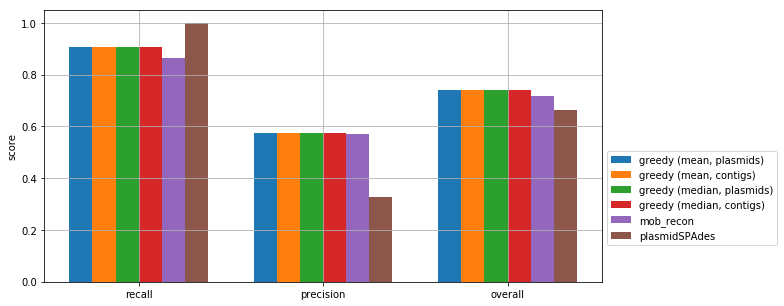

In [5]:
plot_scores([(greedy_mean, 'greedy (mean, plasmids)'), (greedy_mean_contigs, 'greedy (mean, contigs)'), 
             (greedy_median, 'greedy (median, plasmids)'), (greedy_median_contigs, 'greedy (median, contigs)'), 
             (mob_recon, 'mob_recon'), (plasmidspades, 'plasmidSPAdes')], score_labels)

### A) *greedy strategy (mean, plasmids)*

In [6]:
_, _, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, skip_pred_by_all, skip_ref_by_all, \
    skip_mutual, skip_summary_scores = parse_structure(greedy_mean)
num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2
num_mutual = skip_summary_scores - skip_mutual - 2

**List of predicted plasmids**

In [7]:
list_plasmids(greedy_mean, skip_pred_plasmids, num_pred_plasmids)

,plasmid,length (nt)
0,plasmid_0,39599
1,plasmid_1,53845


**Precision and recall**

In [8]:
list_scores(greedy_mean, skip_summary_scores, len(score_labels))

,score,value
0,recall,0.907145
1,precision,0.576227
2,overall,0.741686


**Proportion of reference plasmid (column) covered by individual predicted plasmid (row)**

In [9]:
read_table(greedy_mean, skip_ref_by_pred, num_pred_plasmids, renaming = {'Unnamed: 0': 'predicted'}, col_sums = True)

,predicted,CP020824.1
0,plasmid_0,0.000000
1,plasmid_1,0.907145
2,Total,0.907145


**Proportion of predicted plasmid (column) covered by individual reference plasmid (row)**

In [10]:
read_table(greedy_mean, skip_pred_by_ref, num_ref_plasmids, renaming = {'Unnamed: 0': 'reference'}, col_sums = True)

,reference,plasmid_0,plasmid_1
0,CP020824.1,0.0,1.0
1,Total,0.0,1.0


**Proportion of predicted plasmid collectively covered by all reference plasmids**

In [11]:
read_table(greedy_mean, skip_pred_by_all, num_pred_plasmids)

,plasmid,proportion
0,plasmid_0,0.0
1,plasmid_1,1.0


**Proportion of reference plasmid collectively covered by all predicted plasmids**

In [12]:
read_table(greedy_mean, skip_ref_by_all, num_ref_plasmids)

,plasmid,proportion
0,CP020824.1,0.907145


**High mutual correspondences between reference and predicted plasmids**

A pair of reference and predicted plasmid is included if at least 80 % of the reference are covered by the predicted plasmid and vice versa.

In [13]:
list_correspondences(greedy_mean, skip_mutual, num_mutual)

,reference,prediction,recall,precision
0,CP020824.1,plasmid_1,0.907145,1.0


### B) *greedy strategy (mean, contig collections)*

In [14]:
_, _, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, skip_pred_by_all, skip_ref_by_all, \
    skip_mutual, skip_summary_scores = parse_structure(greedy_mean_contigs)
num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2
num_mutual = skip_summary_scores - skip_mutual - 2

**List of predicted plasmids**

In [15]:
list_plasmids(greedy_mean_contigs, skip_pred_plasmids, num_pred_plasmids)

,plasmid,length (nt)
0,0,39599
1,1,53845


**Precision and recall**

In [16]:
list_scores(greedy_mean_contigs, skip_summary_scores, len(score_labels))

,score,value
0,recall,0.906909
1,precision,0.576227
2,overall,0.741568


**Proportion of reference plasmid (column) covered by individual predicted plasmid (row)**

In [17]:
read_table(greedy_mean_contigs, skip_ref_by_pred, num_pred_plasmids, renaming = {'Unnamed: 0': 'predicted'}, col_sums = True)

,predicted,CP020824.1
0,0,0.000000
1,1,0.906909
2,Total,0.906909


**Proportion of predicted plasmid (column) covered by individual reference plasmid (row)**

In [18]:
read_table(greedy_mean_contigs, skip_pred_by_ref, num_ref_plasmids, renaming = {'Unnamed: 0': 'reference'}, col_sums = True)

,reference,0,1
0,CP020824.1,0.0,1.0
1,Total,0.0,1.0


**Proportion of predicted plasmid collectively covered by all reference plasmids**

In [19]:
read_table(greedy_mean_contigs, skip_pred_by_all, num_pred_plasmids)

,plasmid,proportion
0,0,0.0
1,1,1.0


**Proportion of reference plasmid collectively covered by all predicted plasmids**

In [20]:
read_table(greedy_mean_contigs, skip_ref_by_all, num_ref_plasmids)

,plasmid,proportion
0,CP020824.1,0.906909


**High mutual correspondences between reference and predicted plasmids**

A pair of reference and predicted plasmid is included if at least 80 % of the reference are covered by the predicted plasmid and vice versa.

In [21]:
list_correspondences(greedy_mean_contigs, skip_mutual, num_mutual)

,reference,prediction,recall,precision
0,CP020824.1,1,0.906909,1.0


### C) *greedy strategy (median, plasmids)*

In [22]:
_, _, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, skip_pred_by_all, skip_ref_by_all, \
    skip_mutual, skip_summary_scores = parse_structure(greedy_median)
num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2
num_mutual = skip_summary_scores - skip_mutual - 2

**List of predicted plasmids**

In [23]:
list_plasmids(greedy_median, skip_pred_plasmids, num_pred_plasmids)

,plasmid,length (nt)
0,plasmid_0,39599
1,plasmid_1,53845


**Precision and recall**

In [24]:
list_scores(greedy_median, skip_summary_scores, len(score_labels))

,score,value
0,recall,0.907145
1,precision,0.576227
2,overall,0.741686


**Proportion of reference plasmid (column) covered by individual predicted plasmid (row)**

In [25]:
read_table(greedy_median, skip_ref_by_pred, num_pred_plasmids, renaming = {'Unnamed: 0': 'predicted'}, col_sums = True)

,predicted,CP020824.1
0,plasmid_0,0.000000
1,plasmid_1,0.907145
2,Total,0.907145


**Proportion of predicted plasmid (column) covered by individual reference plasmid (row)**

In [26]:
read_table(greedy_median, skip_pred_by_ref, num_ref_plasmids, renaming = {'Unnamed: 0': 'reference'}, col_sums = True)

,reference,plasmid_0,plasmid_1
0,CP020824.1,0.0,1.0
1,Total,0.0,1.0


**Proportion of predicted plasmid collectively covered by all reference plasmids**

In [27]:
read_table(greedy_median, skip_pred_by_all, num_pred_plasmids)

,plasmid,proportion
0,plasmid_0,0.0
1,plasmid_1,1.0


**Proportion of reference plasmid collectively covered by all predicted plasmids**

In [28]:
read_table(greedy_median, skip_ref_by_all, num_ref_plasmids)

,plasmid,proportion
0,CP020824.1,0.907145


**High mutual correspondences between reference and predicted plasmids**

A pair of reference and predicted plasmid is included if at least 80 % of the reference are covered by the predicted plasmid and vice versa.

In [29]:
list_correspondences(greedy_median, skip_mutual, num_mutual)

,reference,prediction,recall,precision
0,CP020824.1,plasmid_1,0.907145,1.0


### D) *greedy strategy (median, contig collections)*

In [30]:
_, _, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, skip_pred_by_all, skip_ref_by_all, \
    skip_mutual, skip_summary_scores = parse_structure(greedy_median_contigs)
num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2
num_mutual = skip_summary_scores - skip_mutual - 2

**List of predicted plasmids**

In [31]:
list_plasmids(greedy_median_contigs, skip_pred_plasmids, num_pred_plasmids)

,plasmid,length (nt)
0,1,53845
1,0,39599


**Precision and recall**

In [32]:
list_scores(greedy_median_contigs, skip_summary_scores, len(score_labels))

,score,value
0,recall,0.906909
1,precision,0.576227
2,overall,0.741568


**Proportion of reference plasmid (column) covered by individual predicted plasmid (row)**

In [33]:
read_table(greedy_median_contigs, skip_ref_by_pred, num_pred_plasmids, renaming = {'Unnamed: 0': 'predicted'}, col_sums = True)

,predicted,CP020824.1
0,0,0.000000
1,1,0.906909
2,Total,0.906909


**Proportion of predicted plasmid (column) covered by individual reference plasmid (row)**

In [34]:
read_table(greedy_median_contigs, skip_pred_by_ref, num_ref_plasmids, renaming = {'Unnamed: 0': 'reference'}, col_sums = True)

,reference,0,1
0,CP020824.1,0.0,1.0
1,Total,0.0,1.0


**Proportion of predicted plasmid collectively covered by all reference plasmids**

In [35]:
read_table(greedy_median_contigs, skip_pred_by_all, num_pred_plasmids)

,plasmid,proportion
0,0,0.0
1,1,1.0


**Proportion of reference plasmid collectively covered by all predicted plasmids**

In [36]:
read_table(greedy_median_contigs, skip_ref_by_all, num_ref_plasmids)

,plasmid,proportion
0,CP020824.1,0.906909


**High mutual correspondences between reference and predicted plasmids**

A pair of reference and predicted plasmid is included if at least 80 % of the reference are covered by the predicted plasmid and vice versa.

In [37]:
list_correspondences(greedy_median_contigs, skip_mutual, num_mutual)

,reference,prediction,recall,precision
0,CP020824.1,1,0.906909,1.0


### E) *mob_recon (contig collections)*

In [38]:
_, _, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, skip_pred_by_all, skip_ref_by_all, \
    skip_mutual, skip_summary_scores = parse_structure(mob_recon)
num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2
num_mutual = skip_summary_scores - skip_mutual - 2

**List of predicted plasmids**

In [39]:
list_plasmids(mob_recon, skip_pred_plasmids, num_pred_plasmids)

,plasmid,length (nt)
0,plasmid_786,38779
1,plasmid_368,51368


**Precision and recall**

In [40]:
list_scores(mob_recon, skip_summary_scores, len(score_labels))

,score,value
0,recall,0.865189
1,precision,0.569825
2,overall,0.717507


**Proportion of reference plasmid (column) covered by individual predicted plasmid (row)**

In [41]:
read_table(mob_recon, skip_ref_by_pred, num_pred_plasmids, renaming = {'Unnamed: 0': 'predicted'}, col_sums = True)

,predicted,CP020824.1
0,plasmid_368,0.865189
1,plasmid_786,0.000000
2,Total,0.865189


**Proportion of predicted plasmid (column) covered by individual reference plasmid (row)**

In [42]:
read_table(mob_recon, skip_pred_by_ref, num_ref_plasmids, renaming = {'Unnamed: 0': 'reference'}, col_sums = True)

,reference,plasmid_368,plasmid_786
0,CP020824.1,1.0,0.0
1,Total,1.0,0.0


**Proportion of predicted plasmid collectively covered by all reference plasmids**

In [43]:
read_table(mob_recon, skip_pred_by_all, num_pred_plasmids)

,plasmid,proportion
0,plasmid_368,1.0
1,plasmid_786,0.0


**Proportion of reference plasmid collectively covered by all predicted plasmids**

In [44]:
read_table(mob_recon, skip_ref_by_all, num_ref_plasmids)

,plasmid,proportion
0,CP020824.1,0.865189


**High mutual correspondences between reference and predicted plasmids**

A pair of reference and predicted plasmid is included if at least 80 % of the reference are covered by the predicted plasmid and vice versa.

In [45]:
list_correspondences(mob_recon, skip_mutual, num_mutual)

,reference,prediction,recall,precision
0,CP020824.1,plasmid_368,0.865189,1.0


### F) *plasmidSPAdes (contig collections)*

In [46]:
_, _, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, skip_pred_by_all, skip_ref_by_all, \
    skip_mutual, skip_summary_scores = parse_structure(plasmidspades)
num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2
num_mutual = skip_summary_scores - skip_mutual - 2

**List of predicted plasmids**

In [47]:
list_plasmids(plasmidspades, skip_pred_plasmids, num_pred_plasmids)

,plasmid,length (nt)
0,1,39778
1,0,96274
2,2,39337
3,3,10879


**Precision and recall**

In [48]:
list_scores(plasmidspades, skip_summary_scores, len(score_labels))

,score,value
0,recall,0.999798
1,precision,0.326293
2,overall,0.663046


**Proportion of reference plasmid (column) covered by individual predicted plasmid (row)**

In [49]:
read_table(plasmidspades, skip_ref_by_pred, num_pred_plasmids, renaming = {'Unnamed: 0': 'predicted'}, col_sums = True)

,predicted,CP020824.1
0,0,0.999798
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,Total,0.999798


**Proportion of predicted plasmid (column) covered by individual reference plasmid (row)**

In [50]:
read_table(plasmidspades, skip_pred_by_ref, num_ref_plasmids, renaming = {'Unnamed: 0': 'reference'}, col_sums = True)

,reference,0,1,2,3
0,CP020824.1,0.631302,0.0,0.0,0.0
1,Total,0.631302,0.0,0.0,0.0


**Proportion of predicted plasmid collectively covered by all reference plasmids**

In [51]:
read_table(plasmidspades, skip_pred_by_all, num_pred_plasmids)

,plasmid,proportion
0,0,0.631302
1,1,0.000000
2,2,0.000000
3,3,0.000000


**Proportion of reference plasmid collectively covered by all predicted plasmids**

In [52]:
read_table(plasmidspades, skip_ref_by_all, num_ref_plasmids)

,plasmid,proportion
0,CP020824.1,0.999798


**High mutual correspondences between reference and predicted plasmids**

A pair of reference and predicted plasmid is included if at least 80 % of the reference are covered by the predicted plasmid and vice versa.

In [53]:
list_correspondences(plasmidspades, skip_mutual, num_mutual)

No high mutual correspondence found.
